In [ ]:
# libraries I used for this assignment
import pandas as pd 
from pandas import read_csv
from scipy.sparse.coo import coo_matrix
import numpy as np 
from numpy.linalg import eig
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.sparse


In [ ]:
# read the data file
def read_data(filepath):
    data = pd.read_csv(filepath,
                         sep=" ",
                         header=None)
    data.columns = ["col", "row", "data"]
    vals = data["data"]
    cols = data["col"]
    rows = data["row"]

    if min(cols) == 1 and min(rows) == 1:
        cols = [i - 1 for i in cols]
        rows = [i - 1 for i in rows]

    return coo_matrix((vals, (cols, rows))).tocsr()
  

# Spectral Clustering 

In [ ]:
from scipy import sparse

# first, we need to make adjacence matrix to get laplacian matrix
def make_adj_mtx(A):   
    n = A.shape[0]
    adj = np.zeros((n,n)) # initialize to zero
    for i in range (n):
      for j in range (n):
        if A[i, j] != 0: # if data exists
          adj[i, j] = 1
    adj = sparse.csr_matrix(adj)  
    return adj

# we also need to make diagonal matrix to get laplacian matrix
def make_diag_mtx(A):
    n = A.shape[0]
    D = np.zeros((n,n)) # initialize
    for i in range (n):
      rowsum = 0
      for j in range (n):
         rowsum += abs(A[i, j])
      D[i, i] = rowsum
    D = sparse.csr_matrix(D)
    return D

# get laplacian matrix (L = D - A)
def make_Laplacian(diag,adj):
    L = diag - adj
    return L

In [ ]:
def make_edge_vertex_mtx(B): 
    row  = []
    col  = []
    data = []
    l = 0
    for i in range(0, B.indices[-1] + 1):
        for k in range(B.indptr[i], B.indptr[i + 1]):
            j = B.indices[k]
            if i < j:
                data += [1., 1.]
                col  += [i, j]
                row  += [l, l]
                l += 1
    return coo_matrix((data, (row, col))).tocsr()

In [ ]:
from scipy.sparse import csr_matrix

# get eigenvalues of the matrix and find the second minimum eigenvalue
# the smalles eigenvalue is zero and its eigenvector is 1
def get_eigenvalues(A):
    A = csr_matrix(A).toarray()
    eigenvalue, eigenvector = eig(A)
    min_eig = min(eigenvalue)
    return eigenvalue

In [ ]:
# based on the nonzero minimum eigenvalue (lambda 2), get the following eigenvector (X2) -> (Fiedler vector)
# we can do clustering based on the values of the eigenvector (fiedler vector). 
# if the value is greater than zero, the value will be in the aggregate A_1. 
# otherwise (if the value is less than or equal to zero, the value will be in the aggregate A_2)
def get_fiedler(L):
    eigenvector = eigs(L,k=3,which='LM')[1] # fiedler vector
    return eigenvector

In [ ]:
def mtx_for_visualization(B):
    df = pd.DataFrame(columns = ['rows', 'cols'])
    n = B.shape[0]
    for i in range (n):
      for j in range (i + 1, n):
        if B[i,j] == 1:
          new_row = {'rows':i, 'cols':j}
          # append row to the dataframe
          df = df.append(new_row, ignore_index = True)
    edge_vertex = df.to_numpy() # change from df to ndarray
    return edge_vertex

# visualization the spectral clustering
def spectral_clustering_visualization(E, eigenvector):
  rows = len(eigenvector)
  columns = len(eigenvector[0])
  df = pd.DataFrame(E, columns = ['rows', 'cols'])
  df.insert(2, "cluster_labels", [0 for i in range (len(df))], True) # initialize the column cluster_labels to zero
  for i in range (rows):
    for j in range (columns):
      if eigenvector[i, j] > 0:
          df.cluster_labels[i,j] = 1
  
  sns.lmplot('rows', 'cols', data=df, fit_reg=False,  # x-axis, y-axis, data, no line
           scatter_kws={"s": 50}, # marker size
           hue="cluster_labels") # color

# Test Spectral Clustering

The second smallest eigenvalue is: 
 [ 1.81366960e+01  1.70551712e+01  1.33061223e+01  1.09210675e+01
  9.77724095e+00  6.99619703e+00  6.51554463e+00  6.33159222e+00
 -3.03715976e-15  5.37859508e+00  4.68525227e-01  4.58079267e+00
  4.48000767e+00  4.27587682e+00  9.09247664e-01  1.12501072e+00
  1.25940411e+00  1.59928308e+00  1.76189862e+00  1.82605521e+00
  1.95505045e+00  2.48709173e+00  2.74915718e+00  3.01396297e+00
  3.24206748e+00  3.47218740e+00  5.61803399e+00  3.37615409e+00
  2.00000000e+00  3.38196601e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00] 
And its eigenvector (fiedler vector) is: 
 [[-1.93749031e-01+0.j  9.40932167e-01+0.j -9.47825261e-02+0.j]
 [-5.22422164e-03+0.j -6.58647640e-02+0.j  9.91845054e-02+0.j]
 [-2.91860881e-02+0.j -1.15069117e-01+0.j -3.14797911e-01+0.j]
 [ 9.29125708e-03+0.j -5.47579565e-02+0.j  3.37349664e-02+0.j]
 [ 1.12534185e-02+0.j -5.82879065e-02+0.j  7.62221479e-03+0.j]
 [ 1.21560376e-02+0.j -6.33977563e-02+0.j  8.60483

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


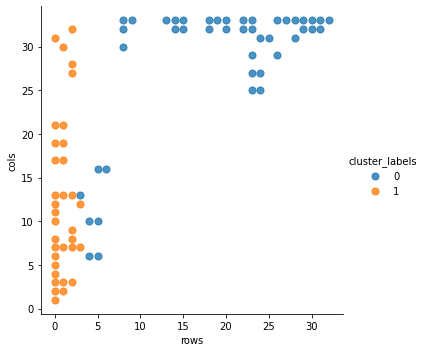

In [ ]:
# Test the solution with Karate Club Graph
karate = read_data("karate_club_graph-1.txt")

# change the sparse matrix to adjacency matrix
adj = make_adj_mtx(karate)

# get the diagonal matrix
diag = make_diag_mtx(karate)

# get the laplacian matrix
laplacian_matrix = make_Laplacian(diag, adj)

# get the edge-vertex matrix using the adjacency matrix
E = make_edge_vertex_mtx(adj)

# get the vertex-edge matrix
E_transpose = np.transpose(E) 

# form the edge-edge matrix
A_E = E @ E_transpose 

# get the second smallest eigenvalue
eigenvalue = get_eigenvalues(laplacian_matrix)

# get the corresponding eigenvector
fiedler = get_fiedler(laplacian_matrix)

print("The second smallest eigenvalue is: \n", eigenvalue ,
      "\nAnd its eigenvector (fiedler vector) is: \n", fiedler)

# visualize the result
B = mtx_for_visualization(adj)
spectral_clustering_visualization(B, fiedler)

The second smallest eigenvalue is: 
 [0.         5.6825447  0.51458628 0.91842497 1.19467204 4.60051893
 4.73186847 4.15309328 5.38426389 5.14292738 1.75256574 0.13646258
 0.13646258 2.90580942 3.61833597 5.518396   5.518396   5.3831767
 5.3831767  5.20210697 5.20210697 5.09446244 5.09446244 2.27346656
 2.4902596  2.63666278 0.75392339 0.75392339 0.98905895 0.98905895
 4.04048527 1.48364039 1.48364039 4.04048527 3.6215454  3.6215454
 3.14205998 3.14205998 2.04486237 2.04486237 2.30538101 2.72665405
 2.30538101 2.72665405 2.5577845  2.5577845 ] 
And its eigenvector (fiedler vector) is: 
 [[ 3.25026425e-01+0.j  2.67713047e-15+0.j -8.60961668e-16+0.j]
 [-2.90632637e-01+0.j  1.36498397e-01+0.j -6.46252103e-02+0.j]
 [-2.90632637e-01+0.j -1.24214378e-01+0.j -8.58975769e-02+0.j]
 [-2.90632637e-01+0.j -1.22840192e-02+0.j  1.50522787e-01+0.j]
 [ 2.19333797e-01+0.j -1.20880917e-01+0.j  1.18027038e-01+0.j]
 [-1.17492009e-01+0.j  5.69340235e-02+0.j -1.54584754e-01+0.j]
 [ 7.29364728e-02+0.j  8.520

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


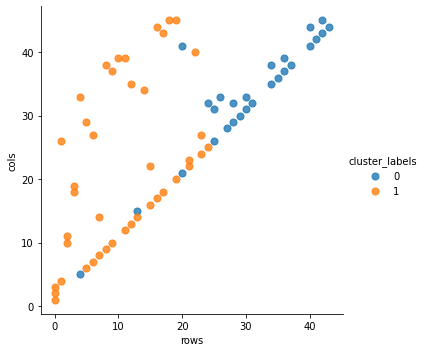

In [ ]:
# Test the solution with Tutee Graph
tutee = read_data("tutee_graph-1.txt")

# change the sparse matrix to adjacency matrix
adj = make_adj_mtx(tutee)

# get the diagonal matrix
diag = make_diag_mtx(tutee)

# get the laplacian matrix
laplacian_matrix = make_Laplacian(diag, adj)

# get the edge-vertex matrix using the adjacency matrix
E = make_edge_vertex_mtx(adj)

# get the vertex-edge matrix
E_transpose = np.transpose(E) 

# form the edge-edge matrix
A_E = E @ E_transpose 

# get the second smallest eigenvalue
eigenvalue = get_eigenvalues(laplacian_matrix)

# get the corresponding eigenvector
fiedler = get_fiedler(laplacian_matrix)

print("The second smallest eigenvalue is: \n", eigenvalue ,
      "\nAnd its eigenvector (fiedler vector) is: \n", fiedler)

# visualize the result
B = mtx_for_visualization(adj)
spectral_clustering_visualization(B, fiedler)

# K-mean Clustering

In [ ]:
def kmeans_clustering(matrix):
  # create data points
  df = pd.DataFrame(columns = ['rows', 'cols'])
  n = matrix.shape[0]

  for i in range (n):
    for j in range (i + 1, n):
      if matrix[i,j] == 1:
        new_row = {'rows':i, 'cols':j}
        # append row to the dataframe
        df = df.append(new_row, ignore_index = True)

  data_points = df.values 

  kmeans = KMeans(n_clusters = 3).fit(data_points)

  # cluster id for each data point
  kmeans.labels_

  # this is final centroids position
  kmeans.cluster_centers_

  df['cluster_id'] = kmeans.labels_

  # visualization
  sns.lmplot('rows', 'cols', data=df, fit_reg=False,  # x-axis, y-axis, data, no line
            scatter_kws={"s": 50}, # marker size
            hue="cluster_id") # color

  # title
  plt.title('After K-mean Clustering')

# Test K-means Clustering

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


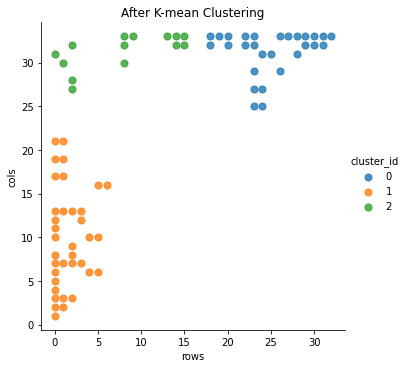

In [ ]:
# Test the solution with Karate Club Graph
karate = read_data("karate_club_graph-1.txt")
kmeans_clustering(karate)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


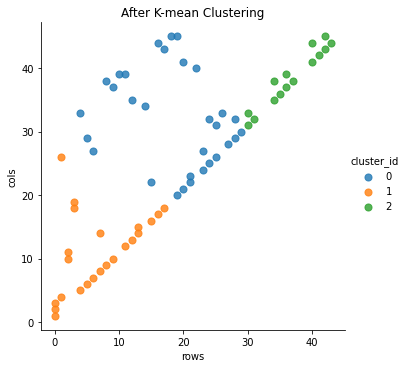

In [ ]:
# Test the solution with Tutee Graph
tutee = read_data("tutee_graph-1.txt")
kmeans_clustering(tutee)